In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from pathlib import Path
import zipfile
import os
import shutil

In [2]:
# Importing the scans from processed_scans folder, 
fileNames = []

# Create an array of all the file names from the processed_scans folder
for root, dirs, files in os.walk('processed_scans'):
	for file in files:
		fileNames.append(file)

# Importing the labels from the csv file
labels = pd.read_csv('oasis_cross-sectional.csv', dtype=str)

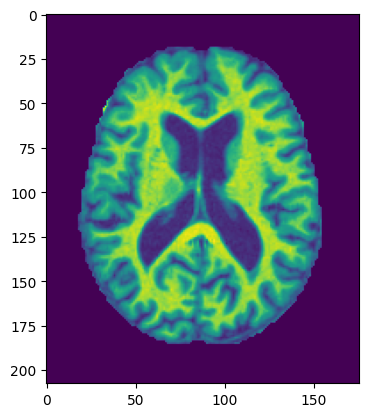

OAS1_0001_MR1.gif
              ID M/F Hand Age Educ SES MMSE CDR  eTIV   nWBV    ASF Delay
0  OAS1_0001_MR1   F    R  74    2   3   29   0  1344  0.743  1.306   NaN


In [3]:
# Display the first image and the label for it
plt.imshow(plt.imread('processed_scans/'+fileNames[0]))
plt.show()
print(fileNames[0])
print(labels[0:1])


In [4]:
image_data = []

for fileName in fileNames:
    img = load_img('processed_scans/'+fileName, target_size=(224, 224))
    img_array = img_to_array(img)
    image_data.append(img_array)

image_data = np.array(image_data)


In [5]:
# Checking to see if there's a corresponding label for each image
checkedLabels = labels[labels['ID'].isin([fileName[:13] for fileName in fileNames])]



In [6]:
def appendToId(id):
	return id + ".png"

# Create a new column in the labels dataframe that contains the file name
checkedLabels['fileNames'] = checkedLabels['ID'].apply(appendToId)

# CDR can be '0.0', '0.5', 'nan', '1.0', '2.0'
# As this is not a scale, but more of a classification, this can be passed as a string, then tokenized
def convertToString(cdr):
	if str(cdr) == 'nan':
		return '0'
	else:
		return str(cdr)

# Convert the CDR column to a float (if it's nan, it will be converted to 0)
checkedLabels['CDR'] = checkedLabels['CDR'].apply(convertToString)


C:\Users\mlg\AppData\Local\Temp\ipykernel_8636\178209912.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  checkedLabels['fileNames'] = checkedLabels['ID'].apply(appendToId)
C:\Users\mlg\AppData\Local\Temp\ipykernel_8636\178209912.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  checkedLabels['CDR'] = checkedLabels['CDR'].apply(convertToString)


In [7]:
# Print all the unique values in the CDR column
print(checkedLabels['CDR'].unique())

['0' '0.5' '1' '2']


In [8]:
train_datagen = ImageDataGenerator(rescale=1./255,
    validation_split=0.2,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=360,
    width_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    dtype = 'float32',
    
) # set validation split


In [15]:
args = dict(
	dataframe=checkedLabels,
	directory='C:\Active-Projects\RHUL-FYP\PROJECT\OASIS\processed_scans',  # This is required to have the full path for some reason
	x_col='fileNames',
	y_col='CDR',
	target_size=(224, 224),
	batch_size=32,
	class_mode='categorical',# Binary = it outputs 1 number, not the probability of each class
	shuffle=True,
	seed=42
)

train_ds = train_datagen.flow_from_dataframe(
	**args,
	subset='training',
)

val_ds = train_datagen.flow_from_dataframe(
	**args,
	subset='validation',
)

Found 348 validated image filenames belonging to 4 classes.
Found 87 validated image filenames belonging to 4 classes.


In [16]:
# Printing out the mapping between checkedLabels and train_ds
print(train_ds.class_indices)


{'0': 0, '0.5': 1, '1': 2, '2': 3}


c:\Users\mlg\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\preprocessing\image.py:1863: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
c:\Users\mlg\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\preprocessing\image.py:1873: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


(32, 224, 224, 3)
Empty DataFrame
Columns: [ID, M/F, Hand, Age, Educ, SES, MMSE, CDR, eTIV, nWBV, ASF, Delay, fileNames]
Index: []
[1. 0. 0. 0.]


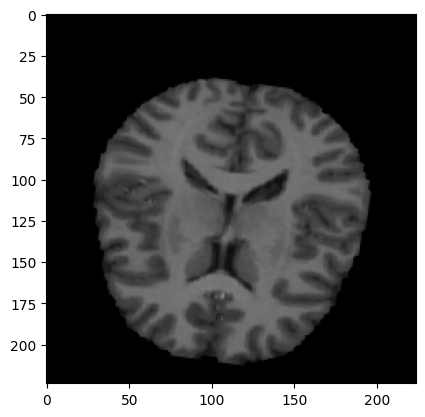

In [17]:
# Show the first image from the training set and the label for it

img, label = train_ds.next()
print(img.shape) 
# print the image label
print(checkedLabels.head(0))
print(label[7])
plt.imshow(img[0])
plt.show()

In [18]:
# Here I'm using the MobileNetV2 model for testing purposes as it is a lightweight model
MobileNetV3Small = keras.applications.MobileNetV3Large(
	input_shape=(224, 224, 3),
	include_top=False, 
	weights='imagenet')


model = Sequential()

# Freezing the layers of the model so that they don't get trained (apart from the last 10)
# This should help the training to not override the feature extraction layers
for layer in MobileNetV3Small.layers[:-10]:
	layer.trainable = False

model.add(MobileNetV3Small)
# Flattening the output of the model to be able to feed it to the dense layer
model.add(Flatten())
# Adding a dense layer with 512 neurons and ReLU activation
model.add(Dense(512, activation='relu'))
# Adding a dropout layer to reduce overfitting
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
# Adding the output layer with 4 neurons and softmax activation, this is because we have 4 classes
# The softmax activation will give us the probability of the image belonging to each class
model.add(Dense(4, activation='softmax'))

# The summary of the model is shown, this is to check if the model is being built correctly
model.summary()

model.compile(
	optimizer=keras.optimizers.Adam(learning_rate=0.0001),
	loss='categorical_crossentropy',
	metrics=['accuracy']
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 flatten_1 (Flatten)         (None, 47040)             0         
                                                                 
 dense_3 (Dense)             (None, 512)               24084992  
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                      

c:\Users\mlg\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\preprocessing\image.py:1863: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
c:\Users\mlg\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\preprocessing\image.py:1873: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/80
11/11 [==============================] - 7s 413ms/step - loss: 3.1045 - accuracy: 0.5776 - val_loss: 1.7269 - val_accuracy: 0.0000e+00
Epoch 2/80
11/11 [==============================] - 3s 295ms/step - loss: 2.0466 - accuracy: 0.6379 - val_loss: 1.6706 - val_accuracy: 0.0000e+00
Epoch 3/80
11/11 [==============================] - 3s 299ms/step - loss: 1.7485 - accuracy: 0.7126 - val_loss: 1.6155 - val_accuracy: 0.0000e+00
Epoch 4/80
11/11 [==============================] - 3s 300ms/step - loss: 1.2656 - accuracy: 0.6293 - val_loss: 1.5432 - val_accuracy: 0.0000e+00
Epoch 5/80
11/11 [==============================] - 3s 303ms/step - loss: 0.9350 - accuracy: 0.6724 - val_loss: 1.5176 - val_accuracy: 0.0000e+00
Epoch 6/80
11/11 [==============================] - 3s 296ms/step - loss: 0.8658 - accuracy: 0.7328 - val_loss: 1.5017 - val_accuracy: 0.0000e+00
Epoch 7/80
11/11 [==============================] - 3s 313ms/step - loss: 0.8960 - accuracy: 0.7155 - val_loss: 1.4874 - val

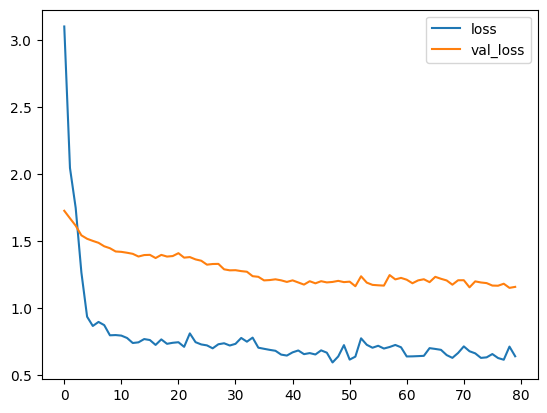

In [19]:
# Fit the model to the training data
history = model.fit(
	train_ds,
	epochs=80,
	validation_data=val_ds,
)

# Plot the training and validation loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()


In [20]:
# Unfreeze all the layers of the model
for layer in MobileNetV3Small.layers:
	layer.trainable = True

# Compile the model again, with a slower learning rate

model.compile(
	optimizer=keras.optimizers.Adam(learning_rate=0.000001),
	loss='categorical_crossentropy',
	metrics=['accuracy']
)

# Fit the model to the training data
history = model.fit(
	train_ds,
	epochs=80,
	validation_data=val_ds,
)

Epoch 1/80
11/11 [==============================] - 10s 413ms/step - loss: 2.2004 - accuracy: 0.5172 - val_loss: 1.1637 - val_accuracy: 0.6667
Epoch 2/80
11/11 [==============================] - 4s 331ms/step - loss: 1.9328 - accuracy: 0.5575 - val_loss: 1.1541 - val_accuracy: 0.7126
Epoch 3/80
11/11 [==============================] - 4s 318ms/step - loss: 1.7051 - accuracy: 0.5805 - val_loss: 1.1568 - val_accuracy: 0.6667
Epoch 4/80
11/11 [==============================] - 3s 315ms/step - loss: 1.7561 - accuracy: 0.5690 - val_loss: 1.1510 - val_accuracy: 0.6667
Epoch 5/80
11/11 [==============================] - 4s 342ms/step - loss: 1.7886 - accuracy: 0.5977 - val_loss: 1.1474 - val_accuracy: 0.6897
Epoch 6/80
11/11 [==============================] - 4s 317ms/step - loss: 1.8851 - accuracy: 0.6149 - val_loss: 1.1535 - val_accuracy: 0.6897
Epoch 7/80
11/11 [==============================] - 4s 318ms/step - loss: 1.6358 - accuracy: 0.6149 - val_loss: 1.1410 - val_accuracy: 0.7816
Epoch

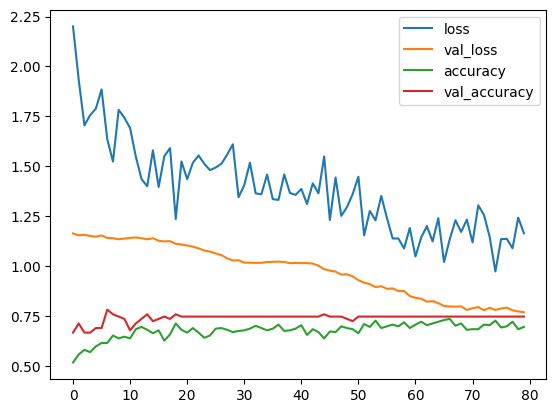

In [22]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [87]:
predictions = model.predict(val_ds)

3/3 [==============================] - 1s 305ms/step


In [88]:
# Compare the predictions to the true labels (in val_ds) and print the results
print('Accuracy: ', np.sum(predictions.argmax(axis=1) == val_ds.classes) / len(val_ds.classes))

Accuracy:  0.7471264367816092


In [89]:
predictionAccuracy = [[], [], [], []]

predictionsList = predictions.tolist()

# predictions lambda
for i in range(len(predictions)):#
  # Get the highest probability in the given prediction, rounding due to floating point errors
  highestProbability = [round(pred, 5) for pred in predictionsList[i]].index(round(max(predictionsList[i]), 5))

  # Check if the highest probability is the same as the true label
  truePrediction = highestProbability == val_ds.classes[i]

  # Append the result to the dictionary
  predictionAccuracy[val_ds.classes[i]].append(truePrediction)

# Print the accuracy of each class]

for pred in predictionAccuracy:
  # Get the number of correct predictions
  correctPredictions = pred.count(True)
  # Get the number of incorrect predictions
  incorrectPredictions = pred.count(False)

  # Print the accuracy of the class
  print(f"Class: {predictionAccuracy.index(pred)} Correct: {correctPredictions} Incorrect: {incorrectPredictions}")


Class: 0 Correct: 65 Incorrect: 0
Class: 1 Correct: 0 Incorrect: 14
Class: 2 Correct: 0 Incorrect: 8
Class: 3 Correct: 0 Incorrect: 0
